In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import sklearn.neighbors
import sklearn.linear_model
import sklearn.tree
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Modify this to point to your data.
data = pandas.read_csv('exams.csv')
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68
...,...,...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73,70,65
996,male,group D,associate's degree,free/reduced,completed,85,91,92
997,female,group C,some high school,free/reduced,none,32,35,41
998,female,group C,some college,standard,none,73,74,82


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [3]:
print((data.isna() | (data == '?')).sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [4]:
bins = [0, 69, 79, 89, 100]  # Define score ranges
labels = [0, 1, 2, 3]  # Assign corresponding labels
data['writing score'] = pandas.cut(data['writing score'], bins=bins, labels=labels, include_lowest=True).astype(int)
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,0
1,female,group D,some high school,free/reduced,none,40,59,0
2,male,group E,some college,free/reduced,none,59,60,0
3,male,group B,high school,standard,none,77,78,0
4,male,group E,associate's degree,standard,completed,78,73,0
...,...,...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73,70,0
996,male,group D,associate's degree,free/reduced,completed,85,91,3
997,female,group C,some high school,free/reduced,none,32,35,0
998,female,group C,some college,standard,none,73,74,2


In [5]:
# make gender binary
# male = 0 
# female = 1
data['gender'] = data['gender'].map({'male': 0, 'female': 1})
# make school lunch binary
# standard = 0 
# free/reduced = 1
data['lunch'] = data['lunch'].map({'standard': 0, 'free/reduced': 1}) 
# make test prep binary
# none = 0 
# completed = 1
data['test preparation course'] = data['test preparation course'].map({'none': 0, 'completed': 1})  # Adjust based on your dataset

data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,group A,high school,0,1,67,67,0
1,1,group D,some high school,1,0,40,59,0
2,0,group E,some college,1,0,59,60,0
3,0,group B,high school,0,0,77,78,0
4,0,group E,associate's degree,0,1,78,73,0
...,...,...,...,...,...,...,...,...
995,0,group C,high school,0,0,73,70,0
996,0,group D,associate's degree,1,1,85,91,3
997,1,group C,some high school,1,0,32,35,0
998,1,group C,some college,0,0,73,74,2


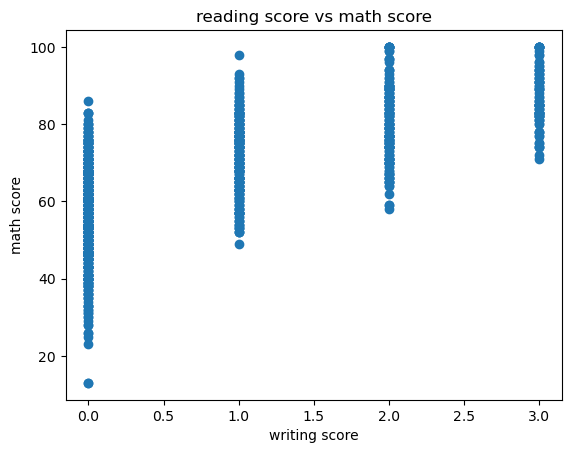

In [6]:
# label vs col_02 - label vs major
x_vals = data['writing score']
y_vals = data['math score']

plt.scatter(x_vals, y_vals)
plt.xlabel('writing score')
plt.ylabel('math score')
plt.title('reading score vs math score')

plt.show()

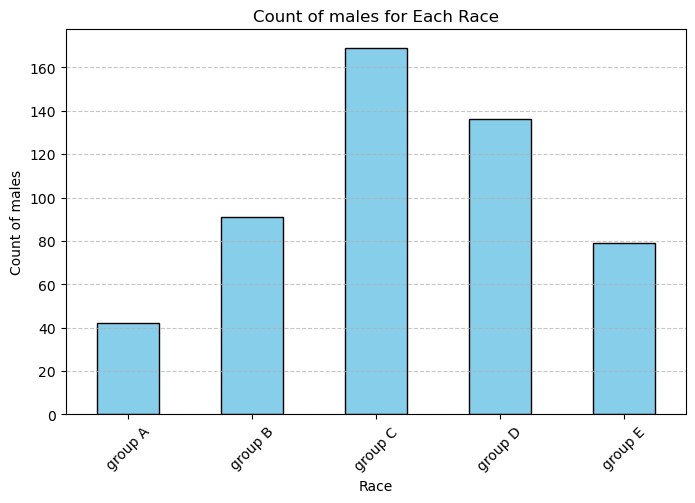

In [7]:
gender_counts = data[data['gender'] == 0].groupby('race/ethnicity')['gender'].count()

# Plot the bar chart
plt.figure(figsize=(8, 5))
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('Race')
plt.ylabel('Count of males')
plt.title('Count of males for Each Race')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [8]:
def create_classifiers():
    return [
        sklearn.neighbors.KNeighborsClassifier(),
        sklearn.linear_model.LogisticRegression(),
        sklearn.tree.DecisionTreeClassifier()
    ]

# Test the function
my_classifiers = create_classifiers()
print(my_classifiers)

[KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier()]


In [9]:
def cross_fold_validation(classifier, frame, folds, categorical_columns=None):
    # Split the frame into features (X) and labels (y)
    X = frame.drop(columns=['writing score']).copy()  # Features (excluding the label column)
    y = frame['writing score'].copy()  # Labels
    
    # One-hot encode the categorical columns if provided
    X = pandas.get_dummies(X, columns=['race/ethnicity', 'parental level of education'], drop_first=True)
    
    # Initialize the StratifiedKFold for k-folds
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    # List to store accuracy scores for each fold
    accuracy_scores = []
    
    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X, y):
        # Split data into training and testing sets based on the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the classifier on the training data
        classifier.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = classifier.predict(X_test)
        
        # Calculate accuracy for this fold and add it to the list
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
    
    # Return the list of accuracy scores for each fold
    return accuracy_scores

my_classifiers_scores = []
results = []
for classifier in my_classifiers:
    accuracy_scores = cross_fold_validation(classifier, data, 5)
    my_classifiers_scores.append(accuracy_scores)
    print("Classifier: %s, Accuracy: %s." % (type(classifier).__name__, accuracy_scores))
    mean_accuracy = numpy.mean(accuracy_scores)
    std_accuracy = numpy.std(accuracy_scores)
    results.append([type(classifier).__name__, mean_accuracy, std_accuracy])
    print(mean_accuracy)
    print(std_accuracy)

Classifier: KNeighborsClassifier, Accuracy: [0.73, 0.795, 0.77, 0.79, 0.73].
0.763
0.02821347195933179
Classifier: LogisticRegression, Accuracy: [0.655, 0.59, 0.635, 0.6, 0.58].
0.612
0.028390139133156807
Classifier: DecisionTreeClassifier, Accuracy: [0.695, 0.755, 0.775, 0.775, 0.745].
0.749
0.029393876913398165


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [20]:
results_df = pandas.DataFrame(results, columns=["Classifier", "Mean Accuracy", "Standard Deviation"])
print(results_df)

               Classifier  Mean Accuracy  Standard Deviation
0    KNeighborsClassifier          0.763            0.028213
1      LogisticRegression          0.612            0.028390
2  DecisionTreeClassifier          0.749            0.029394


In [22]:
def significance_test(a_values, b_values, p_value):
    # Perform a two-sample t-test
    _, p_val = stats.ttest_ind(a_values, b_values)
    
    # return true if the p-value is less than
    return p_val < p_value

for i in range(len(my_classifiers)):
    for j in range(i + 1, len(my_classifiers)):
        significant = significance_test(my_classifiers_scores[i], my_classifiers_scores[j], 0.10)
        print("%s vs %s: %s" % (type(my_classifiers[i]).__name__,
                                type(my_classifiers[j]).__name__, significant))

KNeighborsClassifier vs LogisticRegression: True
KNeighborsClassifier vs DecisionTreeClassifier: False
LogisticRegression vs DecisionTreeClassifier: True
